In [1]:
#in this script we will write code for adapting the given pretrained model to test dataset
# we will follow the ideas in paper: Tent: Fully-Test Time Adaptation by Entropy Minimization by Dequan Wang*, Evan Shelhamer*, Shaoteng Liu, Bruno Olshausen, and Trevor Darrell (ICLR 2021, spotlight).
#the github repo is: https://github.com/DequanWang/tent

# loss function : variance_new + C * ((mean_old - mean_new) ** 2)

In [2]:
#we will load the pretrained optical  flow model, then we will take a couple of frames in test-dataset 
#then we will augument the frames to get 1000 augmented frames
# then we will pass the augmented frames and original frames to the pretrained model
# then we will calculate the entropy of the flow field : 
#the entropy loss function that we define is: variance across all the augmented and original frame optical flow fields + C * change in mean flow field across all augmented and original frames over iterations

# loss function : variance + c * ((mean_old - mean_new) ** 2)
#we will have only the batch normaization layers as trainable layers 
#and the rest of the layers will be frozen
#we will use the loss to train the trainable layers and then we will save the model


In [3]:
#import all libraries fior pytorch data loading
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
#import ImageFolder from torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random


import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils



In [4]:
#enable anomaly detection
torch.autograd.set_detect_anomaly(True)

In [5]:
import importlib

In [6]:
#import model name and pretrained model name from script parameters_new.py
import parameters_new
#reload

importlib.reload(parameters_new)
from parameters_new import MODEL_NAME, PRE_TRAINED_MODEL, CURRENT_MODEL

In [7]:
#we will use pretrained optical flow model from the script: pre_trained_model_wrappers.py
#we import the class: Args
import pre_trained_model_wrapper_new
#reload

importlib.reload(pre_trained_model_wrapper_new)
# from pre_trained_model_wrapper2 import Args      #class storing arguments
#we import functions: build_model ,display_results , return_both_flows , compare_optical_flow 
from pre_trained_model_wrapper_new import build_model, display_results, return_both_flows, compare_optical_flow, get_pretrained_model , get_optical_flow

#class Args: is used to store arguments

# build_model: is used to build the model  'PWCNet' on 'chairs_things_ft_sintel'
# compare_optical_flow: is used to compare the optical flow of two images
#get_pretrained_model: is used to get the pretrained model given model and dataset

Did not load moviepy


In [8]:
#import helper functions from the script in directory: utils_pretrained -> pretrained_model_helper.py
#import the function: pad_to_same_shape , read_image , read_frames , flow_visualization, plot_images, get_metrics
from utils_pretrained.pretrained_model_helpers import pad_to_same_shape , read_image , read_frames , flow_visualization, plot_images, get_metrics

In [9]:
import importlib
import torch
import torch.nn as nn
import torch.jit
#import torchsummary
from torchsummary import summary

In [10]:
import os
import math
import argparse
import imageio
from matplotlib import pyplot as plt

import cv2
from model_selection import select_model

import numpy as np

from copy import deepcopy


In [11]:
#import tabulate
from tabulate import tabulate

In [12]:
TENT_EPOCHS = 50
C = 1

In [13]:
#import model name and pretrained model name from script parameters.py
import parameters
#reload

importlib.reload(parameters)
from parameters import MODEL_NAME, PRE_TRAINED_MODEL, CURRENT_MODEL

In [14]:
# MODEL_NAME = 'PWCNet'   #'PDCNet_plus'

# PRE_TRAINED_MODEL = 'chairs_things_ft_sintel'

# ## parameters for PDCNet_plus on megadepth
# MODEL_NAME = 'PDCNet_plus'
# PRE_TRAINED_MODEL = 'megadepth'

# ## parameters for PWCNet on chairs_things_ft_sintel
# MODEL_NAME = 'PWCNet'
# PRE_TRAINED_MODEL = 'chairs_things_ft_sintel'

# #create aglobal variable current_model by concatenating model name and pretrained model with '_' in between
# CURRENT_MODEL = MODEL_NAME + '_' + PRE_TRAINED_MODEL
OPTIM_ITER = 3
LOCAL_OPTIM_ITER = 16
FLIPPING_CONDITION = False

## parameters for PWCNet_GOCor on chairs_things_ft_sintel
# MODEL_NAME = 'PWCNet_GOCor'
# PRE_TRAINED_MODEL = 'chairs_things_ft_sintel'

In [15]:
#paths to pair of frames
# PATH_TO_IMAGE_1 = 'frames/bt.000.png'
# PATH_TO_IMAGE_2 = 'frames/bt.001.png'
# #3
# PATH_TO_IMAGE_3 = 'frames/bt.002.png'

#same paths just file extension changed to pgm
PATH_TO_IMAGE_1 = 'frames/bt.000.pgm'
PATH_TO_IMAGE_2 = 'frames/bt.001.pgm'
#3
PATH_TO_IMAGE_3 = 'frames/bt.002.pgm'

In [16]:
#we have a folder utility_images where some reference images are stored like middlebury color map guide
PATH_TO_COLOR_MAP_GUIDE = 'icons/index.jpeg'

In [17]:
torch.cuda.empty_cache()
# torch.set_grad_enabled(False) # make sure to not compute gradients for computational performance
torch.backends.cudnn.enabled = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

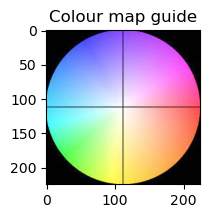

In [18]:

colour_map_guide = read_image(PATH_TO_COLOR_MAP_GUIDE).astype(np.uint8)
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.imshow(colour_map_guide)
ax.set_title('Colour map guide')
plt.show()



In [19]:
#call get_pretrained_model function to get the pretrained model
# model = get_pretrained_model(model_name=MODEL_NAME, pre_trained_model_type=PRE_TRAINED_MODEL )
#print summary of the model
# summary(model, input_size=[(3, 512, 512), (3, 512, 512)])

In [20]:
def configure_model(model):
    """Configure model for use with tent."""
    # train mode, because tent optimizes the model to minimize entropy
    model.train()
    # disable grad, to (re-)enable only what tent updates
    model.requires_grad_(False)
    # configure norm for tent updates: enable grad + force batch statisics
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.requires_grad_(True)
            # force use of batch stats in train and eval modes
            m.track_running_stats = False
            m.running_mean = None
            m.running_var = None
    return model

In [21]:
def collect_params(model):
    """Collect the affine scale + shift parameters from batch norms.

    Walk the model's modules and collect all batch normalization parameters.
    Return the parameters and their names.

    Note: other choices of parameterization are possible!
    """
    params = []
    names = []
    for nm, m in model.named_modules():
        if isinstance(m, nn.BatchNorm2d):
            for np, p in m.named_parameters():
                if np in ['weight', 'bias']:  # weight is scale, bias is shift
                    params.append(p)
                    names.append(f"{nm}.{np}")
    return params, names

In [22]:
#define an optimizer ADAM with learning rate 0.001
#define  the optimizer with learning rate
# optimizer = torch.optim.Adam([{'params': collect_params(model)[0], 'lr': 0.001}])

#write a function to return optimizer
def get_optimizer(model, lr=0.001):
    """Return optimizer for tent updates."""
    # collect parameters and names
    params, names = collect_params(model)
    # define optimizer
    optimizer = torch.optim.Adam([{'params': params, 'lr': 0.001}])
    return optimizer




In [23]:
#define a variable for storing model as global variable
model = get_pretrained_model(model_name=MODEL_NAME, pre_trained_model_type=PRE_TRAINED_MODEL )

Model: PDCNet_plus
Pre-trained-model: megadepth
GOCor: Local iter 16
GOCor: Global iter 3


/home/lisa/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/lisa/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
#we will write a function that will take two images and return the optical flow
#THIS IS TEST TIME ADAPTATOION in which we take two images and return the optical flow and we will adapt the model to the new images
#by minimizing theloss function we defined: variation loss + C * (change in mean)


#this function will accept as parameters: path to augumented examples of frame1, path to augumented examples of frame2






#after the function call , we will again make all the parameters of the model non trainable --  to do


In [25]:
#we will create the dataset and dataloader for the augumented examples of frame1 and frame2
dataset_name = 'corridor'
#the folder inside the dataset folder is named: CURRENT_MODEL
#and inside that we have folder named like: 0_1 , 1_2 , 2_3 , 3_4 , 4_5 , 5_6 , 6_7 , 7_8 , 8_9 , i.e. if index is given by i, then folder name is i_(i+1)
#thus the argument will be index
index = 0
#now we construct the path string to the folder
path_to_folder = 'data/' + dataset_name + '/' + CURRENT_MODEL + '/' + str(index) + '_' + str(index+1)
#now this folder has 2 folders : Frame0 and Frame1
# #we will load both the folders in dataset seperately and while training loop we will zip them together: to get x1 and x2
# #create dataset for Frame0
# dataset_frame0 = ImageFolder(path_to_folder + '/Frame0')
# #create dataset for Frame1
# dataset_frame1 = ImageFolder(path_to_folder + '/Frame1')




In [26]:

#define transforms for both the datasets
#for transforms, we will use the functions from the file: pre_trained_model_wrapper_new.py
#first on th image path : we apply read_image function
#second on the loaded image: we do .astype(np.uint8)
#then we will permute the image to get it in the right format: .permute(2, 0, 1)
#write the transforms
# transform = transforms.Compose([
#     read_image,
#     np.uint8,
#     transforms.ToTensor(),
#     transforms.Lambda(lambda x: x.permute(2, 0, 1))
# ])

#we load the image in transform as per standard pytorch format and methods, and then we permute it to get it in the right format
#we will use the same transform for both the datasets
transform = transforms.Compose([
    #we will load the image as numpy array uint8
    #not use read_image function
    # read_image,
    #convert to numpy array
    
    np.uint8,
    #load image as numpy array

    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.permute(2, 0, 1))
    #permute such that the channels are in last dimension, now it is in first dimension
    # transforms.Lambda(lambda x: x.permute(2, 0, 1))
    #curently the image is in the format: (3, 512, 512), we want it in the format: (512, 512, 3)
    # transforms.Lambda(lambda x: x.permute(1, 2, 0))
])
    

In [27]:
#now create the dataset for both the datasets
dataset_frame0 = ImageFolder(path_to_folder + '/Frame0', transform=transform)
dataset_frame1 = ImageFolder(path_to_folder + '/Frame1', transform=transform)

#now we will create the dataloader for both the datasets
#the batch size will be equal to the dataset size
#we will use the same batch size for both the datasets
batch_size = len(dataset_frame0)
#we will use the same batch size for both the datasets
dataloader_frame0 = DataLoader(dataset_frame0, batch_size=batch_size, shuffle=False)
dataloader_frame1 = DataLoader(dataset_frame1, batch_size=batch_size, shuffle=False)


In [32]:
@torch.enable_grad() 
def variation_loss(input):
    """Return variation loss."""
    #calculate the mean of the input
    mean = input.mean()
    #replicate the mean to the same shape as input
    mean = mean.expand_as(input)
    # compute mean of input
    # mean = input.mean()
    # compute mean square error loss
    #print input shapes
    #print loss function
    print("loss function")
    print('input shape: ', input.shape)
    print('mean shape: ', mean.shape)
    loss = F.mse_loss(input, mean)
    return loss

In [33]:

#step 1 is to configure model for learnable parameters and non learnable parameters
#use the function configure_model
model = configure_model(model)
#load the model to the device
# model = model.to(device)


#define the optimizer
optimizer = get_optimizer(model)

#we will write the loss function,here
# loss function will be: variation loss + C * (change in mean)
#let us write the first part i.e. variation loss
#wee have mean as an argument to the function, then we just apply mean square error loss and that would be the variation loss
#we will write the function for variation loss

@torch.enable_grad() 
def variation_loss(input, mean):
    """Return variation loss."""
    # compute mean of input
    # mean = input.mean()
    # compute mean square error loss
    #print input shapes
    #print loss function
    print("loss function")
    print('input shape: ', input.shape)
    print('mean shape: ', mean.shape)
    loss = F.mse_loss(input, mean)
    return loss

#now we 

#we will write the training loop
#we will loop over the dataloader , both the dataloaders are of same size and we will zip them together to get x1 and x2
#itearte for epochs
iteration=0
for epoch in range(TENT_EPOCHS):
    #
    #iterate over the dataloader
    for x1, x2 in zip(dataloader_frame0, dataloader_frame1):
        #we will get the x1 and x2 from the dataloader
        #we will load the images to the device
        # x1 = x1[0].to(device)
        # x2 = x2[0].to(device)
        x1 = x1[0]
        x2 = x2[0]
        #print the shapes
        # print('x1 shape: ', x1.shape)
        # print('x2 shape: ', x2.shape)
        #send model to the device
        # model = model.to(device)
        #now we run the model on x1 and x2
        optical_flow, confidence = model.estimate_flow_and_confidence_map(x1, x2)
        #calculate the meanof optical flow
        #if epoch is 0, then we will calculate the mean of optical flow
        if iteration == 0:
            #calculate the mean of optical flow
            mean_of_optical_flow = torch.mean(optical_flow)
            #print variance size
            print('mean_of_optical_flow size: ', mean_of_optical_flow.shape)
            iteration += 1
            # print('mean of optical flow: ', mean_of_optical_flow)
        # mean_optical_flow = torch.mean(optical_flow)
            #get variance part of the loss
        variance_loss = variation_loss(optical_flow, mean_of_optical_flow)
        print('variance loss: ', variance_loss)
        #now we will calculate the change in mean
        #calculate current mean
        current_mean = torch.mean(optical_flow)
        #calculate the change in mean
        change_in_mean = torch.abs(current_mean - mean_of_optical_flow)
        # print('change in mean: ', change_in_mean)
        #now we will calculate the total loss
        #use C
        loss = variance_loss + C * change_in_mean
        # print('loss: ', loss)
        #now we will do the backward pass
        loss.backward(retain_graph=True)
        #now we will do the optimizer step
        optimizer.step()
        #now we will zero the gradients
        optimizer.zero_grad()
        #print the loss
        print('Epoch: {} , Loss: {}'.format(epoch, loss.item()))

        

        #we will get the optical flow from the model
#         #we will pass the images to the model
#         #we will get the optical flow
#         #send model to device
#         model = model.to(device)
#         flow = model(x1, x2)
#         #we will get the loss
#         #we will get the loss
#         loss = get_loss(x1, x2, flow)
#         #we will do the backward pass
#         loss.backward()
#         #we will do the optimizer step
#         optimizer.step()
#         #we will zero the gradients
#         optimizer.zero_grad()
#     #we will print the loss
#     print('Epoch: {} , Loss: {}'.format(epoch, loss.item()))



mean_of_optical_flow size:  torch.Size([2, 512, 512])
loss function
input shape:  torch.Size([4, 2, 512, 512])
mean shape:  torch.Size([4, 2, 512, 512])
variance loss:  tensor(868.4962, device='cuda:0', grad_fn=<MseLossBackward0>)


RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
#we write 

In [ ]:
# #print size of both the datasets
# print('Size of dataset_frame0: ', len(dataset_frame0))
# print('Size of dataset_frame1: ', len(dataset_frame1))
# #dimension of the image
# # print (type(dataset_frame0[0][0]) )

# #iterate through the dataloader for one iter, use break: to print size of the image and plot the image
# for x1 in dataloader_frame0:
#     print('Size of x1: ', len(x1))
#     #plot the image
#     # plt.imshow(x1[0].permute(1, 2, 0))
#     # plt.show()
#     plt.imshow(x1[0][0])
#     break
#     #plot the image
#     # plt.imshow(x1[0].permute(1, 2, 0))
#     # plt.show()
#     break



In [ ]:
#check the ouput of the model, the shape and dimensions of the output
# trash_output = model(x1, x2)
#write a function to check the output of the model
# def test_output():
#     #load the two images PATH_TO_IMAGE_1 and PATH_TO_IMAGE_2
#     #use the function read_image
#     img1 = read_image(PATH_TO_IMAGE_1)
#     img2 = read_image(PATH_TO_IMAGE_2)
#     #convert the images to numpy array
#     image_1_numpy = img1.astype(np.uint8)
#     image_2_numpy = img2.astype(np.uint8)
#     image_1 = torch.from_numpy(image_1_numpy).permute(2, 0, 1).unsqueeze(0)
#     image_2 = torch.from_numpy(image_2_numpy).permute(2, 0, 1).unsqueeze(0)

#     #print the shape of the images
#     print('Shape of image_1: ', image_1.shape)
#     print('Shape of image_2: ', image_2.shape)

#     output1, output2 = model.estimate_flow_and_confidence_map(image_1, image_2)


#     #print the shape of the output
#     print('Shape of the output1: ', output1.shape)
#     #print type of the output
#     print('Type of the output: ', type(output1))

#     #output2
#     #print the shape of the output
#     print('Shape of the output: ', output2.shape)

# #call the function
# test_output()



In [ ]:
# #test the transform on path_to_image_1
# transform_out = transform(PATH_TO_IMAGE_1)

In [ ]:
# #print dimensions of the transformed image
# print(transform_out.shape)


In [ ]:
#now we will write the training loop

In [ ]:

#loss function is variance + c * ((mean_old - mean_new) ** 2)
#we will define the first part of variance
#define variance loss function

#we define variance part of loss
#this loss function will take prediction of a batch of images and return the variance of the batch
#it will calculate first the mean of the batch and then the variance as MSE between the mean and each prediction
def variance_loss(pred):
    #we calculate the mean of the batch
    mean = torch.mean(pred, dim=0)
    #we calculate the MSE between the mean and each prediction
    loss = torch.mean((pred - mean) ** 2)
    return loss

In [ ]:

@torch.enable_grad()  # ensure grads in possible no grad context for testing
def forward_and_adapt(x, model, optimizer):
    """Forward and adapt model on batch of data.

    Measure entropy of the model prediction, take gradients, and update params.
    """
    # forward
    outputs = model(x)
    #print dimensions of the output
    print('output dimensions: ', outputs.shape)
    ##calculate mean of the batch prediction
    mean_batch = torch.mean(outputs)

    #print dimensions of mean_batch 
    print('mean_batch shape: ', mean_batch.shape)
    # adapt
    loss = 

    ##
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return outputs

SyntaxError: invalid syntax (4004521054.py, line 17)

In [ ]:
#let us define the TENT class


class Tent(nn.Module):
    """Tent adapts a model by entropy minimization during testing.

    Once tented, a model adapts itself by updating on every forward.
    """
    def __init__(self, model, optimizer, epochs=1):
        super().__init__()
        self.model = model
        self.optimizer = optimizer
        self.epochs = epochs
        assert epochs > 0, "tent requires >= 1 step(s) to forward and update"
     

    def forward(self, x):
        """Forward and update the model."""

        for _ in range(self.epochs):
            outputs = forward_and_adapt(x, self.model, self.optimizer)

        return outputs


In [ ]:
# #check if there are batch normalization layers in the model
# for m in model.modules():
#     if isinstance(m, nn.BatchNorm2d):
#         print(m)
#         #inside loop
#         print('inside loop')



In [ ]:
# #check if there are batch normalization layers in the model
# for m in model.modules():
#     if isinstance(m, nn.BatchNorm2d):
#         print(m)
#         #inside loop
#         print('inside loop')